## calcuate learned tunings in each individual ripple during POST and quantify their place field fidelity
#### What percentage of particpating units within each ripple change their spatial tuning compared with their place field

In [188]:
import os
import scipy.io
from scipy.stats import ranksums
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from learned_tuning.learned_tuning import calculate_learned_tuning_individual_ripples, calculate_place_field_fidelity_of_learned_tuning

normalize_to_max = lambda x:(x/np.nanmax(x))


data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# included_session_IDX = [x for x in range(17) if x not in (12, 13)]
# included_session_IDX = [x for x in range(5, 17) if x not in (12,13)] # Grosmark sessions
included_session_IDX = [1]

# included_session_IDX = [14, 15, 16]

sessions = [sessions[i] for i in included_session_IDX]

for sesison_idx, session_name in enumerate(sessions):

    print(session_name)

    session_dataset_path = os.path.join(data_dir, session_name)
    session_number = included_session_IDX[sesison_idx]

    #--------------------------------------------------------------------------------------------
    # Load epochs information

    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs = session_info["behavior"][0][0][0][0]["time"]


     #----------------------------------------------------------------------------------------------
    # Load spike data
    filename = f'{session_name}.spikes_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    spikes_pyr = mat_file["spikes_pyr"]


    # Load unit stability information

    filename = f'{session_name}.cluster_quality_by_block'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    cluster_quality_by_block = mat_file['cluster_quality_by_block'][0]



    #### Extracting all place fields from the imported .mat file
    spatial_tuning_smoothed = spikes_pyr["spatialTuning_smoothed"]


    if session_number in [6,7]:
        num_units = spatial_tuning_smoothed.shape[0] # for RatN and RatS
    else:
        num_units = spatial_tuning_smoothed[0].shape[0]
        
    num_pos_bins = spatial_tuning_smoothed[0][0]['uni'][0][0].size

    # print(num_units, num_pos_bins)

    spikes = []; # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units):
        
        # Create dictionaries for each unit and store the matrices
        
        unit_spikes = dict()
        
        unit_spikes['place_fields']  = {}
        unit_spikes['peak_pos_bins'] = {}
        unit_spikes['peak_firing_rate'] = {}

        
        for direction in running_directions:
            try:
                if session_number in [6,7]:
                    unit_spikes['place_fields'][direction] = spatial_tuning_smoothed[unit][0][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][unit][0][direction][0][0][0][0]
                    unit_spikes['peak_firing_rate'][direction] = spikes_pyr['peakFR'][unit][0][direction][0][0][0][0]
                else:
                    unit_spikes['place_fields'][direction] = spatial_tuning_smoothed[0][unit][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]
                    unit_spikes['peak_firing_rate'][direction] = spikes_pyr['peakFR'][0][unit][direction][0][0][0][0]


            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1

        if session_number in [9, 10]: # for Rat V sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][1]
            unit_spikes['shank_id']  += 1
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][0]

        elif session_number in [6, 7]: # for RatN and RatS
            unit_spikes['spike_times'] = spikes_pyr['time'][unit][0] 
            unit_spikes['shank_id']    = spikes_pyr['id'][unit][0][0][0]
            unit_spikes['cluster_id']  = spikes_pyr['id'][unit][0][0][1]

        elif session_number == 8: # RatU  
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # shank indices already starts at zero
            unit_spikes['shank_id']    += 1
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]
        else: # Grosmark, Hiro, and all other sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # need to go one down for the other datasets
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]



        spikes.append(unit_spikes) 



    # place fields by pooling spikes across both running directions
    place_fields_uni = []
    for unit in range(num_units):
        place_fields_uni.append(spikes[unit]['place_fields']['uni'])
    place_fields_uni = np.array(place_fields_uni)

    place_fields_uni[place_fields_uni == 0] = 1e-4
    active_units = np.where(np.nanmax(place_fields_uni, axis=1) > 1)[0]



    # --------------------------------------------------------------------------------------------
    # Load cluster quality data (L-ratios)
    
    filename = f'{session_name}.clusterQuality.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)

    # Access data structure
    num_shanks = len(mat_file["clusterQuality"]["Lratio"][0])

    L_ratios = list()
    for shank in range(num_shanks):    
        curr_shank_L_ratios = dict()
        curr_shank_L_ratios["L_ratios"] = mat_file["clusterQuality"]["Lratio"][0][shank]
        curr_shank_L_ratios["cluster_ids"] = mat_file["clusterQuality"]["clus"][0][shank]
        
        L_ratios.append(curr_shank_L_ratios)



    #-------------------------------------------------------------------------------------------
    # Loading the population burst evenst with all their corresponding measured lfp features

    overwrite = False # in case we need to read the .mat file again, if there was a change

    filename = f'{session_name}.PBEs.pkl'
    file_path = os.path.join(session_dataset_path, filename)

    if os.path.exists(file_path) and overwrite == False:

        # PBEs = np.load(file_path, allow_pickle=True)
        PBEs = pd.read_pickle(file_path)
    else: # if it doesn't exist then read it from the .mat file

        filename = f'{session_name}.PBEInfo_replayScores_with_spindle_and_deltaPowers.mat'
        file_path = os.path.join(session_dataset_path, filename)
        f = h5py.File(file_path, "r")
        PBEInfo = f['PBEInfo_replayScores']    
       

        # Store the population burst events in a pandas DataFrame
        num_PBEs = PBEInfo["fr_1msbin"].shape[0]
        attributes = list(PBEInfo.keys())

        PBEs = pd.DataFrame(columns=[attr for attr in attributes[1:] ]) # if attr not in ['posteriorProbMat', 'postMat_nonNorm']

        # Loop over the PBEs and add each one as a row to the DataFrame
        num_dots = int(num_PBEs * (10/100))
        count = 0

        for pbe in range(num_PBEs): #  
  
            for attr in PBEs.columns:
                ref = PBEInfo[attr][pbe][0]
                obj = f[ref]

                if attr in ['epoch', 'brainState']: # convert the ascii code to string
                    arr = np.array(obj).flatten()
                    epoch = "".join(chr(code) for code in arr)
                    PBEs.at[pbe, attr] = epoch
                elif attr in ['fr_1msbin', 'fr_20msbin', 'posteriorProbMat', 'postMat_nonNorm']: # no need to flatten
                    arr = np.array(obj)
                    PBEs.at[pbe, attr] = arr
                else: 
                    arr = np.array(obj).flatten()
                    PBEs.at[pbe, attr] = arr

            if (pbe+1) % num_dots == 1:
                count += 1
                message = "Importing PBEs" + "." * count
                print(message, end="\r")

        print("All PBEs were imported") 
    
        filename = f'{session_name}.PBEs.pkl'
        file_path = os.path.join(session_dataset_path, filename)
        PBEs.to_pickle(file_path)

    num_PBEs = PBEs.shape[0]



Achilles_11012013
This session has only one running direction


In [ ]:

    # calculate the learned tunings for individual ripple events

    time_bin_duration = 0.02
    num_PF_shuffles = 10000

    epoch_names = ['pre']

    for epoch in epoch_names:
        if epoch == 'pre':
            epoch_idx = 0
            epoch_duration = epochs[0,1] - epochs[0,0]
        elif epoch == 'run':
            epoch_idx = 1
            epoch_duration = epochs[1,1] - epochs[1,0]
        elif epoch == 'post':
            epoch_idx = 2
            epoch_duration = 4*60*60 # limiting to the first 4 hours of post sleep

        if_inside_epoch = PBEs['peakT'].between(epochs[epoch_idx,0], epochs[epoch_idx,0]+epoch_duration)

        PBEs_subselect = PBEs[if_inside_epoch]
        PBEs_subselect.reset_index(drop=True, inplace=True)

        PBEs_subselect = calculate_learned_tuning_individual_ripples(PBEs_subselect, spikes, L_ratios, time_bin_duration)



In [ ]:
import matplotlib.gridspec as gridspec
import scipy.ndimage as ndimage

def gaussian_kernel(sigma, half_width):
    size= 2*half_width+1
    x,y = np.mgrid[-half_width:half_width+1, -half_width:half_width+1]
    exponent = -(x**2+y**2)/(2*sigma**2)
    kernel = np.exp(exponent)
    return kernel/kernel.sum()


sigma = 2
half_width = 2
kernel = gaussian_kernel(sigma, half_width)

place_fields = np.full((num_units, num_pos_bins), np.nan)
peak_PF_firing = np.full((num_units,), np.nan)
peak_PF_positions = np.full((num_units,), np.nan)

for unit in range(num_units):
    place_fields[unit] = spikes[unit]['place_fields']['uni']
    peak_PF_firing[unit] = spikes[unit]['peak_firing_rate']['uni']
    peak_PF_positions[unit] = spikes[unit]['peak_pos_bins']['uni']

units_with_place_field = np.where(peak_PF_firing > 5)[0] # indexes of the units with peak place field passing a threshold

peak_place_field_sorting_IDX = np.argsort(peak_PF_positions[units_with_place_field]) # peak location-sorting indexes of the units with peak place field passing the threshold
unit_sort_idx = units_with_place_field[peak_place_field_sorting_IDX] # the main indexes when reading from all units

place_fields = place_fields / place_fields.max(axis= 1, keepdims=True)
place_fields = place_fields[unit_sort_idx]



nrows = 20
ncols = 6

plt.figure(figsize = (40, 40))
G = gridspec.GridSpec(nrows, ncols*4, hspace = 0.5, wspace = 0.5)

# fig_outer, axes_outer = plt.subplots(nrows = nrows, ncols = ncols, figsize = (10,8))

# PBE_IDX = 54

selected_PBEs_IDX = np.where(PBEs_subselect['rt_ui'] > 50)[0]
PBEs_to_plot = [selected_PBEs_IDX[i] for i in range(120, 240)]



count = 0
flag = 0
for i in range(nrows):
    if flag == 1:
        break
    for j in range(ncols):

        count += 1

        if count > len(PBEs_to_plot)-1:
            flag = 1
            break

        PBE_IDX = PBEs_to_plot[count]
        
        example_PBE_unit_firing = PBEs_subselect.at[PBE_IDX, 'fr_1msbin'].transpose()[unit_sort_idx]
        active_units = np.any(example_PBE_unit_firing, axis=1)
        num_time_bins = example_PBE_unit_firing.shape[1]


        # example_PBE_unit_firing = ndimage.convolve(example_PBE_unit_firing, kernel, mode = 'constant', cval = 0.0)

        example_PBE_posterior = PBEs_subselect.at[PBE_IDX, 'posteriorProbMat'].transpose()

        example_PBE_learned_tuning = PBEs_subselect.at[PBE_IDX, 'learned_tuning'][unit_sort_idx]
        example_PBE_learned_tuning = example_PBE_learned_tuning / example_PBE_learned_tuning.max(axis=1, keepdims = True)



        axes_1 = plt.subplot(G[i, j*4+0])
        axes_1.imshow(example_PBE_unit_firing[active_units], vmax = 1, origin = 'lower', cmap = 'Greys', aspect='auto', interpolation = 'none') # 
        axes_1.set_title(f"pbe {int(PBEs_subselect.at[PBE_IDX, 'n'])}")
        axes_1.set_xlim([-0.5, num_time_bins+0.5])

        axes_2 = plt.subplot(G[i, j*4+1])
        axes_2.imshow(example_PBE_posterior, vmax=np.nanmax(example_PBE_posterior.flatten())*0.5, origin = 'lower', cmap = 'copper', aspect='auto', interpolation = 'none')

        axes_3 = plt.subplot(G[i, j*4+2])
        axes_3.imshow(example_PBE_learned_tuning[active_units], origin = 'lower', cmap = 'inferno', aspect = 'auto', interpolation = 'none')

        axes_4 = plt.subplot(G[i, j*4+3])
        axes_4.imshow(place_fields[active_units], origin = 'lower', cmap = 'Reds', aspect = 'auto', interpolation = 'none')


filename = f'{session_name}.learned_tuning_indiv_PBEs_all.pdf'
file_path = os.path.join(session_dataset_path, filename)
plt.savefig(file_path, format = 'pdf', dpi = 300)


In [303]:
len(selected_PBEs_IDX)

667

/tmp/ipykernel_70363/961420410.py:56: RuntimeWarning: invalid value encountered in divide
  example_PBE_learned_tuning = example_PBE_learned_tuning / example_PBE_learned_tuning.max(axis=1, keepdims = True)
/tmp/ipykernel_70363/961420410.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


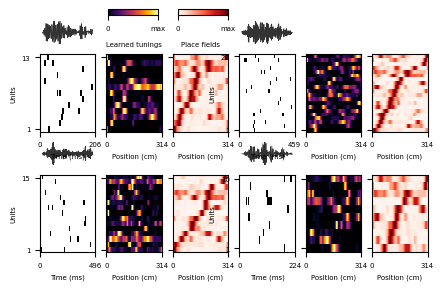

In [333]:
from scipy.signal import convolve
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the 1D Gaussian kernel
sigma = 3
size = 6  # Kernel size (odd number)
kernel = np.fromfunction(
    lambda x: (1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-((x - (size-1)/2)**2)/(2*sigma**2)),
    (size,),
    dtype=int
)
kernel = kernel / np.sum(kernel)



# plot hand-selected PBEs

# select_pbe_n = [10353, 7548, 8280, 9691, 8807, 8721, 7308, 8478, 9830, 9683] , 
# select_pbe_n = [9691, 7308, 8721, 9830] # replays
select_pbe_n = [7537, 7517, 7585, 7116]

nrows = 2
ncols = 2
fontsize = 5

fig = plt.figure(figsize = (5, 3))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['image.interpolation'] = 'nearest'
G = gridspec.GridSpec(nrows*2, ncols*3, height_ratios= [0.3, 1]*nrows, hspace = 0.2, wspace = 0.2)

PBEs_to_plot =np.where(np.isin(PBEs_subselect['n'], select_pbe_n))[0]

count = 0
flag = 0
for i in range(nrows):

    if flag == 1:
        break

    for j in range(ncols):

        if count > len(PBEs_to_plot)-1:
            flag = 1
            break
        
        PBE_IDX = PBEs_to_plot[count]
        
        example_PBE_unit_firing = PBEs_subselect.at[PBE_IDX, 'fr_1msbin'].transpose()[unit_sort_idx]
        active_units = np.where(np.any(example_PBE_unit_firing, axis=1))[0]
        num_active_units = active_units.shape[0]
        num_time_bins = example_PBE_unit_firing.shape[1]
        example_PBE_unit_firing = np.apply_along_axis(lambda row: convolve(row, kernel, mode='same'), axis=1, arr=example_PBE_unit_firing)


        example_PBE_learned_tuning = PBEs_subselect.at[PBE_IDX, 'learned_tuning'][unit_sort_idx]
        example_PBE_learned_tuning = example_PBE_learned_tuning / example_PBE_learned_tuning.max(axis=1, keepdims = True)

        axes_0 = plt.subplot(G[i*2, j*3+0])
        rippleWave = PBEs_subselect.at[PBE_IDX, 'rippleWave']
        peakT = int(PBEs_subselect.at[PBE_IDX, 'peakT']*1000)
        startT = int(PBEs_subselect.at[PBE_IDX, 'startT']*1000)
        endT = int(PBEs_subselect.at[PBE_IDX, 'endT']*1000)

        rippleWave2 = rippleWave[(startT - (peakT-700)) : (endT - (peakT-700))]
        axes_0.plot(rippleWave2, color = 'k', alpha=0.8, label='Ripple LFP', linewidth = 0.5)
        axes_0.set_ylim([np.min(rippleWave2), np.max(rippleWave2)])
        axes_0.set_frame_on(False)
        axes_0.set_xticks([])
        axes_0.set_yticks([])
        axes_0.tick_params(axis='both', which='major', labelsize=fontsize)  # Adjust fontsize as needed


        axes_1 = plt.subplot(G[i*2+1, j*3+0])
        binned_firing_to_plot = example_PBE_unit_firing[active_units]
        binned_firing_to_plot = (binned_firing_to_plot > 0).astype(int)

        im_1 = axes_1.imshow(binned_firing_to_plot, origin = 'lower', cmap = 'binary', aspect='auto', interpolation = 'none')
        # axes_1.set_title(f"pbe {int(PBEs_subselect.at[PBE_IDX, 'n'])}", fontsize = fontsize)
        axes_1.set_xlim([0, num_time_bins])
        axes_1.set_xticks([0, num_time_bins])
        axes_1.set_yticks([0, num_active_units-1], [1, num_active_units])
        axes_1.set_ylabel('Units', fontsize = fontsize)

        axes_1.set_xlabel('Time (ms)', fontsize = fontsize)
        axes_1.tick_params(axis='both', which='major', labelsize=fontsize)  # Adjust fontsize as needed



        axes_2 = plt.subplot(G[i*2+1, j*3+1])
        im_2 = axes_2.imshow(example_PBE_learned_tuning[active_units], origin = 'lower', cmap = 'inferno', aspect = 'auto', interpolation = 'none')
        axes_2.set_xlim([0, num_pos_bins])
        axes_2.set_xticks([0, num_pos_bins], [0, num_pos_bins*2])
        axes_2.set_yticks([0, num_active_units-1], [])
        axes_2.set_xlabel('Position (cm)', fontsize = fontsize)
        if count == 0:
            axes_2.set_title('Learned tunings', fontsize = fontsize)
        axes_2.tick_params(axis='both', which='major', labelsize=fontsize)  # Adjust fontsize as needed

            


        axes_3 = plt.subplot(G[i*2+1, j*3+2])
        im_3 = axes_3.imshow(place_fields[active_units], origin = 'lower', cmap = 'Reds', aspect = 'auto', interpolation = 'none')
        axes_3.set_xlim([0, num_pos_bins])
        axes_3.set_xticks([0, num_pos_bins], [0, num_pos_bins*2])
        axes_3.set_yticks([0, num_active_units-1], [])
        axes_3.set_xlabel('Position (cm)', fontsize = fontsize)
        if count == 0:
            axes_3.set_title('Place fields', fontsize = fontsize)
        axes_3.tick_params(axis='both', which='major', labelsize=fontsize)  # Adjust fontsize as needed


        count += 1


# Add colorbars for the 'inferno' and 'Reds' colormaps
cbar_ax_2 = fig.add_axes([0.26, 0.90, 0.1, 0.02])  # Adjust these coordinates and dimensions as needed
cbar_ax_3 = fig.add_axes([0.40, 0.90, 0.1, 0.02])  # Adjust these coordinates and dimensions as needed
cbar_2 = plt.colorbar(im_2, cax=cbar_ax_2, orientation='horizontal')
cbar_2.set_ticks([0, 1])
cbar_2.set_ticklabels(['0', 'max'], fontsize = fontsize)
cbar_3 = plt.colorbar(im_3, cax=cbar_ax_3, orientation='horizontal')
cbar_3.set_ticks([0, 1])
cbar_3.set_ticklabels(['0', 'max'], fontsize = fontsize)

plt.tight_layout()


filename = f'{session_name}.learned_tuning_indiv_PBEs_non_replays.pdf'
file_path = os.path.join(session_dataset_path, filename)
plt.savefig(file_path, format = 'pdf', dpi = 300)


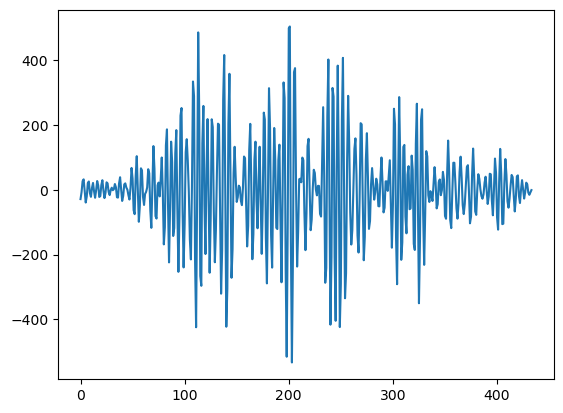

In [258]:
# When I was saving the ripple wave for each PBE I stored all data points from 700 ms before to 700 ms after the  PBE peak T (time resolution = 1 ms)

plt.figure()
rippleWave = PBEs_subselect.at[PBE_IDX, 'rippleWave']
peakT = int(PBEs_subselect.at[PBE_IDX, 'peakT']*1000)
startT = int(PBEs_subselect.at[PBE_IDX, 'startT']*1000)
endT = int(PBEs_subselect.at[PBE_IDX, 'endT']*1000)

rippleWave2 = rippleWave[(startT - (peakT-700)-50) : (endT - (peakT-700)+50)]

plt.plot(rippleWave2)


In [307]:
count

11

In [253]:
(endT - (peakT-700))

856

In [289]:
session_name


'Achilles_11012013'